<h1 style="text-align: center;color:#82cc1a">Hybrid Anime Recommendation System</h1>

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')
%matplotlib inline
sns.set(style='whitegrid', context='talk')

SEED = 11
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
print(f"Random seed set to {SEED}")

Random seed set to 11


<h1 style="text-align: center;color:#647b389">Reading Data</h1>

In [2]:
RAW_DIR = os.path.join("..", "artifacts/raw")

anime_df = pd.read_csv(RAW_DIR+"/anime.csv", low_memory=True)
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [3]:
anime_df.describe()


,MAL_ID,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch
count,17562.000000,17562.000000,1.756200e+04,17562.000000,17562.000000,1.756200e+04,17562.000000,17562.000000,17562.000000
mean,21477.192347,8763.452340,3.465854e+04,457.746270,2231.487758,2.209557e+04,955.049653,1176.599533,8199.831227
std,14900.093170,5059.327278,1.252821e+05,4063.473313,14046.688133,9.100919e+04,4275.675096,4740.348653,23777.691963
min,1.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000
25%,5953.500000,4383.500000,3.360000e+02,0.000000,13.000000,1.110000e+02,6.000000,37.000000,112.000000
50%,22820.000000,8762.500000,2.065000e+03,3.000000,73.000000,8.175000e+02,45.000000,77.000000,752.500000
75%,35624.750000,13145.000000,1.322325e+04,31.000000,522.000000,6.478000e+03,291.750000,271.000000,4135.500000
max,48492.000000,17565.000000,2.589552e+06,183914.000000,887333.000000,2.182587e+06,187919.000000,174710.000000,425531.000000


In [4]:
rating_df = pd.read_csv(RAW_DIR+"/animelist.csv", low_memory=True)
rating_df.info()
rating_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 5 columns):
 #   Column            Dtype
---  ------            -----
 0   user_id           int64
 1   anime_id          int64
 2   rating            int64
 3   watching_status   int64
 4   watched_episodes  int64
dtypes: int64(5)
memory usage: 228.9 MB


,user_id,anime_id,rating,watching_status,watched_episodes
count,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06
mean,9.960794e+03,1.655395e+04,4.289415e+00,3.079064e+00,1.230280e+01
std,5.659825e+03,1.379685e+04,3.907219e+00,1.770329e+00,1.737191e+02
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.199000e+03,3.269000e+03,0.000000e+00,2.000000e+00,0.000000e+00
50%,1.013600e+04,1.253100e+04,6.000000e+00,2.000000e+00,3.000000e+00
75%,1.480200e+04,3.090100e+04,8.000000e+00,6.000000e+00,1.200000e+01
max,1.968200e+04,4.849100e+04,1.000000e+01,6.000000e+00,6.553500e+04


In [5]:
rating_df.sample(8)

,user_id,anime_id,rating,watching_status,watched_episodes
1226342,4183,11319,6,2,12
2287783,7691,1530,0,6,0
1096356,3715,6553,7,2,1
1250499,4294,18153,9,2,12
2385497,8000,1210,9,2,24
3699486,12256,7044,8,2,2
3934064,12994,7148,7,2,12
4511951,14851,18857,2,2,3


<h1 style="text-align: center;color:#647b389">Data Processing</h1>

In [6]:
#### Check Duplicates
print(f"rating_df has {rating_df.duplicated().sum()} duplicates")
print(f"anime_df has {anime_df.duplicated().sum()} duplicates")

rating_df has 0 duplicates
anime_df has 0 duplicates


In [7]:
### check for missing values
print(f"rating_df has {rating_df.isnull().sum().sum()} missing values")
print(f"anime_df has {anime_df.isnull().sum().sum()} missing values")

rating_df has 0 missing values
anime_df has 0 missing values


In [8]:
ratings_cnt = rating_df['rating'].value_counts()
print(f"Rating counts:\n{ratings_cnt}")
print("===="*10)
print(f"Rating dist: {rating_df['rating'].describe()}")

Rating counts:
rating
0     2536655
8      857524
7      791908
9      570117
6      417415
10     392277
5      224832
4      103060
3       50741
2       30534
1       24937
Name: count, dtype: int64
Rating dist: count    6.000000e+06
mean     4.289415e+00
std      3.907219e+00
min      0.000000e+00
25%      0.000000e+00
50%      6.000000e+00
75%      8.000000e+00
max      1.000000e+01
Name: rating, dtype: float64


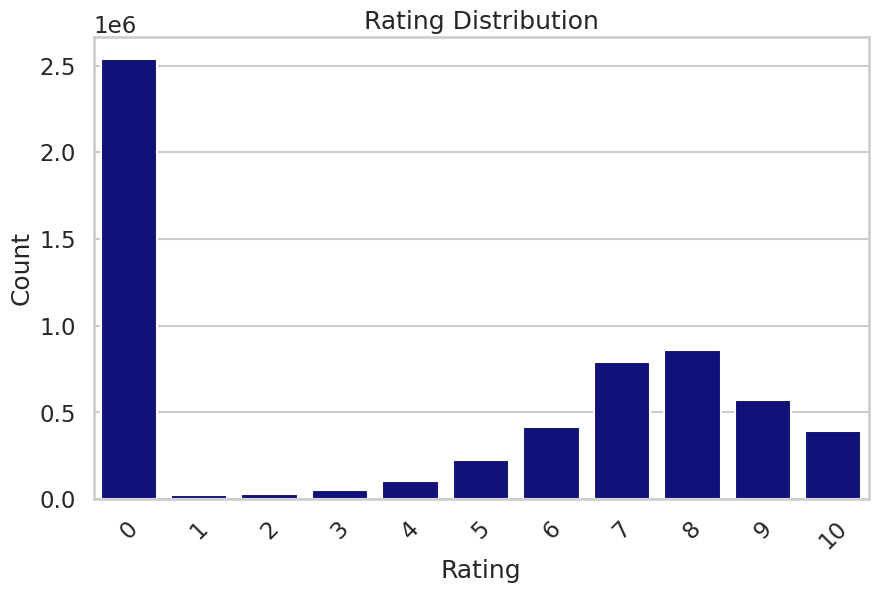

In [9]:

plt.figure(figsize=(10, 6))
sns.countplot(data=rating_df, x='rating', order=range(11), color='darkblue')
## Else use order = rating_cnt.index to get the order from the counts
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show();

Scaling the ratings data to a range of 0 to 1:

In [10]:
ratings_cnt.index

Index([0, 8, 7, 9, 6, 10, 5, 4, 3, 2, 1], dtype='int64', name='rating')

In [11]:
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])

rating_df['rating'] = rating_df['rating'].apply(lambda x : (x-min_rating)/(max_rating-min_rating)).values.astype(np.float16)

In [12]:
rating_df['rating'].describe()

count    6.000000e+06
mean              NaN
std      0.000000e+00
min      0.000000e+00
25%      0.000000e+00
50%      6.000977e-01
75%      7.998047e-01
max      1.000000e+00
Name: rating, dtype: float64

Someone who has rated over 300 anine titles is likely to be a serious anime fan. We will use this as a threshold to filter our dataset.

In [13]:
NUM_REVIEW_THRESHOLD = 300

n_ratings = rating_df['user_id'].value_counts()
# print(f"Rating per user (Before cleaing):\n{n_ratings}")
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= NUM_REVIEW_THRESHOLD].index)]
n_ratings = rating_df['user_id'].value_counts()
# print(f"Rating per user (After cleaing):\n{rating_df['user_id'].value_counts()}")

In [14]:
rating_df

,user_id,anime_id,rating,watching_status,watched_episodes
213,2,24833,0.0,1,0
214,2,235,1.0,1,100
215,2,36721,0.0,1,1
216,2,40956,0.0,1,0
217,2,31933,0.0,1,3
...,...,...,...,...,...
5999247,19675,3974,0.0,6,0
5999248,19675,4654,0.0,6,0
5999249,19675,4896,0.0,6,0
5999250,19675,3322,0.0,6,0


#### UserID and AnimeID encoding and decoding

In [15]:
### USer to ID mapping
user_ids = rating_df['user_id'].unique().tolist()
userId_2_encodedUserId_mapping = {x:i for (i,x) in enumerate(user_ids)}
encodedUserId_2_userId_mapping = {i:x for (i,x) in enumerate(user_ids)}

In [16]:
for i in range(10):
    print(f"org userID:{encodedUserId_2_userId_mapping[i]}  ||  encoded ID:{userId_2_encodedUserId_mapping[encodedUserId_2_userId_mapping[i]]}")

org userID:2  ||  encoded ID:0
org userID:3  ||  encoded ID:1
org userID:6  ||  encoded ID:2
org userID:12  ||  encoded ID:3
org userID:16  ||  encoded ID:4
org userID:17  ||  encoded ID:5
org userID:19  ||  encoded ID:6
org userID:21  ||  encoded ID:7
org userID:34  ||  encoded ID:8
org userID:41  ||  encoded ID:9


In [17]:
rating_df['encoded_userID'] = rating_df['user_id'].map(userId_2_encodedUserId_mapping)
rating_df[['user_id', 'encoded_userID']].sample(7)

,user_id,encoded_userID
2391741,8022,2824
5828023,19125,6805
3546254,11746,4110
839933,2844,976
3188650,10682,3714
1147354,3911,1350
1970851,6715,2340


In [18]:
n_users = len(userId_2_encodedUserId_mapping)
print(f"Total number of users (with >= {NUM_REVIEW_THRESHOLD} reviews): {n_users}")

Total number of users (with >= 300 reviews): 7013


In [19]:
### Anime ID encoding
anime_ids = rating_df['anime_id'].unique().tolist()
animeId_2_encodedAnimeId_mapping = {x:i for (i,x) in enumerate(anime_ids)}
encodedAnimeId_2_animeId_mapping = {i:x for (i,x) in enumerate(anime_ids)}

for i in range(10):
    print(f"org animeID:{encodedAnimeId_2_animeId_mapping[i]}  ||  encoded ID:{animeId_2_encodedAnimeId_mapping[encodedAnimeId_2_animeId_mapping[i]]}")

org animeID:24833  ||  encoded ID:0
org animeID:235  ||  encoded ID:1
org animeID:36721  ||  encoded ID:2
org animeID:40956  ||  encoded ID:3
org animeID:31933  ||  encoded ID:4
org animeID:5042  ||  encoded ID:5
org animeID:7593  ||  encoded ID:6
org animeID:21  ||  encoded ID:7
org animeID:35446  ||  encoded ID:8
org animeID:24  ||  encoded ID:9


In [20]:
rating_df['encoded_animeID'] = rating_df['anime_id'].map(animeId_2_encodedAnimeId_mapping)
rating_df[['anime_id', 'encoded_animeID']].sample(7)

,anime_id,encoded_animeID
639321,19383,4377
348528,31859,178
4533191,30544,1387
4597459,34984,3514
5129409,1972,949
2015772,40713,14503
3345533,9107,2059


In [21]:
n_animes = len(animeId_2_encodedAnimeId_mapping)
print(f"Total number of animes: {n_animes}")

Total number of animes: 17200


#### Random shuffling of the dataset

In [22]:
rating_df = rating_df.sample(frac=1, random_state=SEED).reset_index(drop=True)

#### Splitting the dataset into training and testing sets

In [23]:
X = rating_df[['encoded_userID', 'encoded_animeID']].values
y = rating_df['rating'].values

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (4583100, 2), y shape: (4583100,)


In [27]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.005
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (4560184, 2), Y_train shape: (4560184,)
X_test shape: (22916, 2), Y_test shape: (22916,)


In [ ]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
### First column is Encoded_userID, second column is Encoded_animeID
X_test_array = [X_test[:, 0], X_test[:, 1]]

print(f"X_train_array[0] shape: {X_train_array[0].shape}, X_train_array[1] shape: {X_train_array[1].shape}")
print(f"X_test_array[0] shape: {X_test_array[0].shape}, X_test_array[1] shape: {X_test_array[1].shape}")

X_train_array[0] shape: (4560184,), X_train_array[1] shape: (4560184,)
X_test_array[0] shape: (22916,), X_test_array[1] shape: (22916,)


In [29]:
X_test_array

[array([4113, 4441, 3288, ..., 1477,  130, 1360]),
 array([ 353, 1676, 1366, ..., 1393, 4427, 1010])]

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau



In [36]:
def RecommendNet():
    EMBEDDING_SIZE = 128
    user = Input(name='user_input', shape=[1])
    user_embedding = Embedding(input_dim=n_users, output_dim=EMBEDDING_SIZE, name='user_embedding')(user)
    anime = Input(name='anime_input', shape=[1])
    anime_embedding = Embedding(input_dim=n_animes, output_dim=EMBEDDING_SIZE, name='anime_embedding')(anime)

    x = Dot(axes=2, normalize=True)([user_embedding, anime_embedding])
    x = Flatten()(x)
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dropout(0.2)(x)
    model = Model(inputs=[user, anime], outputs=x)  
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    return model


<h1 style="text-align: center;color:#647b389">Model Training</h1>

In [73]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 1024
NUM_EPOCHS = 10

In [57]:
user_ids_train = torch.tensor(X_train[:, 0], dtype=torch.long)
anime_ids_train = torch.tensor(X_train[:, 1], dtype=torch.long)
ratings_train = torch.tensor(Y_train, dtype=torch.float)

user_ids_test = torch.tensor(X_test[:, 0], dtype=torch.long)
anime_ids_test = torch.tensor(X_test[:, 1], dtype=torch.long)
ratings_test = torch.tensor(Y_test, dtype=torch.float)

In [60]:
print(len(user_ids_train.shape))

1


In [61]:
if len(ratings_train.shape) == 1:
    ratings_train = ratings_train.unsqueeze(1)  # Shape: (num_samples, 1)
if len(ratings_test.shape) == 1:
    ratings_test = ratings_test.unsqueeze(1)

In [38]:
n_users, n_animes = len(userId_2_encodedUserId_mapping), len(animeId_2_encodedAnimeId_mapping)
print(f"Number of users: {n_users}, Number of animes: {n_animes}")

Number of users: 7013, Number of animes: 17200


In [ ]:
class RecommenderNet(nn.Module):
    def __init__(self, EMBEDDING_SIZE=128, N_USERS=7013, N_ANIMES=17200):
        super().__init__()

        self.embedding_dim = EMBEDDING_SIZE
        self.n_users = N_USERS
        self.n_animes = N_ANIMES
        
        # Remove the trailing commas
        self.user_emb_layer = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.embedding_dim)
        self.anime_emb_layer = nn.Embedding(num_embeddings=self.n_animes, embedding_dim=self.embedding_dim)

        self.dense1 = nn.Linear(in_features=1, out_features=1)
        self.bn1 = nn.BatchNorm1d(num_features=1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.2)

    def forward(self, user, anime):
        # user: tensor of shape (batch_size,)
        # anime: tensor of shape (batch_size,)

        # Get embeddings
        user_emb = self.user_emb_layer(user)  # Shape: (batch_size, embedding_size)
        anime_emb = self.anime_emb_layer(anime)  # Shape: (batch_size, embedding_size)

        # Normalize embeddings (L2 norm)
        user_emb_norm = user_emb / torch.norm(user_emb, dim=1, keepdim=True)
        anime_emb_norm = anime_emb / torch.norm(anime_emb, dim=1, keepdim=True)

        # Compute cosine similarity (DOT proD)
        x = torch.sum(user_emb_norm * anime_emb_norm, dim=1, keepdim=True)  # Shape (BS, 1)

        x = self.dense1(x)  # Shape (BS, 1)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        return x

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_users = len(userId_2_encodedUserId_mapping)
n_animes = len(animeId_2_encodedAnimeId_mapping)
model = RecommenderNet(EMBEDDING_SIZE=128, N_USERS=n_users, N_ANIMES=n_animes).to(DEVICE)
summary(model, input_size=[(1,), (1,)], dtypes=[torch.long, torch.long], col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
RecommenderNet                           [1]                       [1, 1]                    --                        True
├─Embedding: 1-1                         [1]                       [1, 128]                  897,664                   True
├─Embedding: 1-2                         [1]                       [1, 128]                  2,201,600                 True
├─Linear: 1-3                            [1, 1]                    [1, 1]                    2                         True
├─BatchNorm1d: 1-4                       [1, 1]                    [1, 1]                    2                         True
├─ReLU: 1-5                              [1, 1]                    [1, 1]                    --                        --
├─Dropout: 1-6                           [1, 1]                    [1, 1]                    --                        --
Total p

#### DAtaLoader and Dataset

In [69]:
train_dataset = TensorDataset(user_ids_train, anime_ids_train, ratings_train)
test_dataset = TensorDataset(user_ids_test, anime_ids_test, ratings_test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [71]:
def train_rec_net(model, train_loader, test_loader, num_epochs=25, lr=1e-3, device='cuda'):
    model.train()
    model.to(device)

    optimizer = optim.Adam(params=model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    metrics = {
        'train_losses': [],
        'train_maes': [],
        'val_losses': [],
        'val_maes': []
    }

    for epoch in tqdm(range(num_epochs), colour='green', desc='Epoch'):
        model.train()
        total_train_loss = 0.0
        total_train_mae = 0.0
        num_train_batches = 0

        for user, anime, rating in train_loader:
            user = user.to(device)
            anime = anime.to(device)
            rating = rating.to(device).float()

            optimizer.zero_grad()
            predictions = model(user, anime)
            loss = criterion(predictions, rating)
            mae = torch.mean(torch.abs(predictions - rating))

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_mae += mae.item()
            num_train_batches += 1

        avg_train_loss = total_train_loss / num_train_batches
        avg_train_mae = total_train_mae / num_train_batches
        metrics['train_losses'].append(avg_train_loss)
        metrics['train_maes'].append(avg_train_mae)

        model.eval()
        total_val_loss = 0.0
        total_val_mae = 0.0
        num_val_batches = 0

        with torch.no_grad():
            for user, anime, rating in test_loader:
                user = user.to(device)
                anime = anime.to(device)
                rating = rating.to(device).float()

                predictions = model(user, anime)
                loss = criterion(predictions, rating)
                mae = torch.mean(torch.abs(predictions - rating))

                total_val_loss += loss.item()
                total_val_mae += mae.item()
                num_val_batches += 1

        avg_val_loss = total_val_loss / num_val_batches
        avg_val_mae = total_val_mae / num_val_batches
        metrics['val_losses'].append(avg_val_loss)
        metrics['val_maes'].append(avg_val_mae)

        tqdm.write(f"Epoch {epoch+1}/{num_epochs} | "
                   f"Train Loss: {avg_train_loss:.4f} | Train MAE: {avg_train_mae:.4f} | "
                   f"Val Loss: {avg_val_loss:.4f} | Val MAE: {avg_val_mae:.4f}")

    return metrics

In [72]:
metrics = train_rec_net(model, train_loader, test_loader, num_epochs=NUM_EPOCHS, lr=1e-3, device=DEVICE)

Epoch:   5%|▌         | 1/20 [00:37<11:45, 37.12s/it]

Epoch 1/20 | Train Loss: 0.1064 | Train MAE: 0.2087 | Val Loss: 0.0907 | Val MAE: 0.2273


Epoch:  10%|█         | 2/20 [01:17<11:45, 39.19s/it]

Epoch 2/20 | Train Loss: 0.1051 | Train MAE: 0.2064 | Val Loss: 0.0960 | Val MAE: 0.2341


Epoch:  15%|█▌        | 3/20 [02:04<12:03, 42.56s/it]

Epoch 3/20 | Train Loss: 0.1041 | Train MAE: 0.2045 | Val Loss: 0.0993 | Val MAE: 0.2373


Epoch:  20%|██        | 4/20 [02:51<11:47, 44.19s/it]

Epoch 4/20 | Train Loss: 0.1034 | Train MAE: 0.2030 | Val Loss: 0.0941 | Val MAE: 0.2305


Epoch:  25%|██▌       | 5/20 [03:36<11:09, 44.62s/it]

Epoch 5/20 | Train Loss: 0.1026 | Train MAE: 0.2014 | Val Loss: 0.0977 | Val MAE: 0.2350


Epoch:  30%|███       | 6/20 [04:24<10:40, 45.75s/it]

Epoch 6/20 | Train Loss: 0.1018 | Train MAE: 0.1999 | Val Loss: 0.0977 | Val MAE: 0.2331


Epoch:  35%|███▌      | 7/20 [05:11<09:58, 46.06s/it]

Epoch 7/20 | Train Loss: 0.1009 | Train MAE: 0.1983 | Val Loss: 0.0954 | Val MAE: 0.2284


Epoch:  40%|████      | 8/20 [05:50<08:48, 44.00s/it]

Epoch 8/20 | Train Loss: 0.1005 | Train MAE: 0.1972 | Val Loss: 0.0973 | Val MAE: 0.2337


Epoch:  45%|████▌     | 9/20 [06:34<08:02, 43.84s/it]

Epoch 9/20 | Train Loss: 0.0999 | Train MAE: 0.1960 | Val Loss: 0.0952 | Val MAE: 0.2287


Epoch:  50%|█████     | 10/20 [07:16<07:13, 43.33s/it]

Epoch 10/20 | Train Loss: 0.0993 | Train MAE: 0.1947 | Val Loss: 0.0969 | Val MAE: 0.2328


Epoch:  55%|█████▌    | 11/20 [07:59<06:29, 43.31s/it]

Epoch 11/20 | Train Loss: 0.0988 | Train MAE: 0.1938 | Val Loss: 0.0949 | Val MAE: 0.2270


Epoch:  60%|██████    | 12/20 [08:42<05:44, 43.07s/it]

Epoch 12/20 | Train Loss: 0.0983 | Train MAE: 0.1927 | Val Loss: 0.0934 | Val MAE: 0.2252


Epoch:  65%|██████▌   | 13/20 [09:27<05:06, 43.80s/it]

Epoch 13/20 | Train Loss: 0.0978 | Train MAE: 0.1916 | Val Loss: 0.0980 | Val MAE: 0.2310


Epoch:  70%|███████   | 14/20 [10:13<04:26, 44.48s/it]

Epoch 14/20 | Train Loss: 0.0975 | Train MAE: 0.1909 | Val Loss: 0.0944 | Val MAE: 0.2263


Epoch:  75%|███████▌  | 15/20 [10:58<03:43, 44.63s/it]

Epoch 15/20 | Train Loss: 0.0971 | Train MAE: 0.1899 | Val Loss: 0.0968 | Val MAE: 0.2290


Epoch:  80%|████████  | 16/20 [11:38<02:53, 43.28s/it]

Epoch 16/20 | Train Loss: 0.0968 | Train MAE: 0.1892 | Val Loss: 0.0980 | Val MAE: 0.2297


Epoch:  85%|████████▌ | 17/20 [12:18<02:06, 42.24s/it]

Epoch 17/20 | Train Loss: 0.0963 | Train MAE: 0.1882 | Val Loss: 0.0969 | Val MAE: 0.2273


Epoch:  90%|█████████ | 18/20 [12:57<01:22, 41.14s/it]

Epoch 18/20 | Train Loss: 0.0961 | Train MAE: 0.1876 | Val Loss: 0.0965 | Val MAE: 0.2264


Epoch:  95%|█████████▌| 19/20 [13:34<00:40, 40.12s/it]

Epoch 19/20 | Train Loss: 0.0957 | Train MAE: 0.1868 | Val Loss: 0.0949 | Val MAE: 0.2252


Epoch: 100%|██████████| 20/20 [14:13<00:00, 42.66s/it]

Epoch 20/20 | Train Loss: 0.0952 | Train MAE: 0.1859 | Val Loss: 0.0963 | Val MAE: 0.2264


In [81]:
# Extract the embedding weights
user_embeddings = model.user_emb_layer.weight.data  # Shape: (n_users, embedding_dim)
anime_embeddings = model.anime_emb_layer.weight.data  # Shape: (n_animes, embedding_dim)

# Normalize the embeddings (L2 normalization, same as in the forward method)
user_embeddings_norm = user_embeddings / (torch.norm(user_embeddings, dim=1, keepdim=True) + 1e-8)
anime_embeddings_norm = anime_embeddings / (torch.norm(anime_embeddings, dim=1, keepdim=True) + 1e-8)

# Convert to NumPy arrays for further use
user_embeddings_norm_np = user_embeddings_norm.cpu().numpy()  # Shape: (7013, 128)
anime_embeddings_norm_np = anime_embeddings_norm.cpu().numpy()  # Shape: (17200, 128)

# Print shapes to confirm
print(f"Normalized user embeddings shape: {user_embeddings_norm_np.shape}")
print(f"Normalized anime embeddings shape: {anime_embeddings_norm_np.shape}")

Normalized user embeddings shape: (7013, 128)
Normalized anime embeddings shape: (17200, 128)


In [ ]:
torch.save({
    "user_embeddings": user_embeddings_norm,
    "anime_embeddings": anime_embeddings_norm
}, "normalized_embeddings.pt")

# checkpoint = torch.load("normalized_embeddings.pt", map_location='cpu')
# user_embeddings_loaded = checkpoint["user_embeddings"]
# anime_embeddings_loaded = checkpoint["anime_embeddings"]

In [162]:
import h5py

with h5py.File("normalized_embeddings.h5", "w") as f:
    f.create_dataset("user_embeddings", data=user_embeddings_norm.cpu().numpy())
    f.create_dataset("anime_embeddings", data=anime_embeddings_norm.cpu().numpy())

# with h5py.File("normalized_embeddings.h5", "r") as f:
#     user_embeddings_loaded = torch.tensor(f["user_embeddings"][:])
#     anime_embeddings_loaded = torch.tensor(f["anime_embeddings"][:])

<h1 style="text-align: center;color:#647b389">Handling `Anime.csv`</h1>

In [83]:

anime_df = pd.read_csv(RAW_DIR+"/anime.csv", low_memory=True)
anime_df.info()
anime_df 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",Unknown,盗墓笔记之秦岭神树,ONA,Unknown,"Apr 4, 2021 to ?",Unknown,...,Unknown,Unknown,Unknown,1.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
17558,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",Unknown,見える子ちゃん,TV,Unknown,2021 to ?,Unknown,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
17559,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Higurashi:When They Cry – SOTSU,ひぐらしのなく頃に卒,TV,Unknown,"Jul, 2021 to ?",Summer 2021,...,1.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
17560,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",Unknown,ヤマノススメ Next Summit,TV,Unknown,Unknown,Unknown,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


In [86]:
print(anime_df.isna().sum().sum())
anime_df = anime_df.replace("Unknown", np.nan)


75470


In [114]:
def get_anime_name(anime_id): ## org anime id (not the encoded ones from animelist)
    try:
        row = anime_df[anime_df.MAL_ID == anime_id]
        name = row["English name"].values[0]
        if pd.isna(name):
            name = row["Name"].values[0]
        return name
    except:
        print("error while retriving anime name")


In [115]:
cnt=0
for i in range(10):
    x = get_anime_name(i)
    if x is None:
        cnt+=1
    else:
        print(x)
print(cnt)

error while retriving anime name
Cowboy Bebop
error while retriving anime name
error while retriving anime name
error while retriving anime name
Cowboy Bebop:The Movie
Trigun
Witch Hunter Robin
Beet the Vandel Buster
error while retriving anime name
5


In [116]:
anime_df["eng_version"] = anime_df.MAL_ID.apply(lambda x: get_anime_name(x))
print(anime_df["eng_version"].loc[:10])

0                   Cowboy Bebop
1         Cowboy Bebop:The Movie
2                         Trigun
3             Witch Hunter Robin
4         Beet the Vandel Buster
5                   Eyeshield 21
6               Honey and Clover
7     Hungry Heart: Wild Striker
8         Initial D Fourth Stage
9                        Monster
10                        Naruto
Name: eng_version, dtype: object


In [117]:
anime_df.sort_values(by=["Score"],
                     inplace=True,
                     ascending=False,
                     kind="quicksort",
                     na_position="last"
                    )

In [118]:
anime_df.head(8)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,401507.0,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,63756.0,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,275960.0,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,239451.0,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,37902.0,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,Gintama Season 4
6474,11061,Hunter x Hunter (2011),9.1,"Action, Adventure, Fantasy, Shounen, Super Power",Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,TV,148,"Oct 2, 2011 to Sep 24, 2014",Fall 2011,...,304741.0,167331.0,65085.0,18241.0,7789.0,2780.0,1243.0,1054.0,4602.0,Hunter x Hunter
6006,9969,Gintama',9.08,"Action, Sci-Fi, Comedy, Historical, Parody, Sa...",Gintama Season 2,銀魂',TV,51,"Apr 4, 2011 to Mar 26, 2012",Spring 2011,...,44740.0,24294.0,9584.0,3222.0,1655.0,694.0,338.0,437.0,2910.0,Gintama Season 2
741,820,Ginga Eiyuu Densetsu,9.07,"Military, Sci-Fi, Space, Drama",Legend of the Galactic Heroes,銀河英雄伝説,OVA,110,"Jan 8, 1988 to Mar 17, 1997",NaN,...,11497.0,7096.0,3577.0,1570.0,965.0,480.0,264.0,509.0,2265.0,Legend of the Galactic Heroes


In [119]:
anime_df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'eng_version'],
      dtype='object')

In [140]:
anime_df = anime_df[["MAL_ID", "eng_version", "Score", "Genres", "Episodes", "Type", "Studios", "Completed", "Rating", "Producers", "Duration", "Members"]]
anime_df

,MAL_ID,eng_version,Score,Genres,Episodes,Type,Studios,Completed,Rating,Producers,Duration,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Bones,1644938,R - 17+ (violence & profanity),"Aniplex, Square Enix, Mainichi Broadcasting Sy...",24 min. per ep.,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,MAPPA,553,R - 17+ (violence & profanity),"Production I.G, Dentsu, Mainichi Broadcasting ...",23 min. per ep.,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,White Fox,1134756,PG-13 - Teens 13 or older,"Frontier Works, Media Factory, Movic, AT-X, Ka...",24 min. per ep.,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Wit Studio,906824,R - 17+ (violence & profanity),"Production I.G, Dentsu, Mainichi Broadcasting ...",23 min. per ep.,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Bandai Namco Pictures,167130,PG-13 - Teens 13 or older,"TV Tokyo, Aniplex, Dentsu",24 min. per ep.,404121
...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,NaN,"Adventure, Mystery, Supernatural",NaN,ONA,NaN,0,NaN,NaN,NaN,354
17558,48483,Mieruko-chan,NaN,"Comedy, Horror, Supernatural",NaN,TV,Passione,0,NaN,Kadokawa,NaN,7010
17559,48488,Higurashi:When They Cry – SOTSU,NaN,"Mystery, Dementia, Horror, Psychological, Supe...",NaN,TV,NaN,0,R - 17+ (violence & profanity),NaN,NaN,11309
17560,48491,Yama no Susume: Next Summit,NaN,"Adventure, Slice of Life, Comedy",NaN,TV,8bit,2,PG-13 - Teens 13 or older,Kadokawa,NaN,1386


In [144]:
def getAnimeFrame(anime, df):
    try:
        if isinstance(anime, int):
            return df[df.MAL_ID == anime]
        elif isinstance(anime, str):
            return df[df.eng_version == anime]
        else:
            print("NOT FOUND ", anime)
    except:
        print(f"{anime} not found in given dataframe")


In [145]:
getAnimeFrame(471, anime_df)

,MAL_ID,eng_version,Score,Genres,Episodes,Type,Studios,Completed,Rating,Producers,Duration,Members
442,471,To Heart 2,6.52,"Comedy, Drama, Harem, Romance, School, Slice o...",13,TV,OLM,8472,PG-13 - Teens 13 or older,NaN,24 min. per ep.,18154


<h1 style="text-align: center;color:#647b389">Handling `Anime_with_synopsis.csv`</h1>

In [152]:
synopsis_df = pd.read_csv(RAW_DIR + "/anime_with_synopsis.csv", low_memory=True)
synopsis_df.info()
synopsis_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16214 entries, 0 to 16213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   MAL_ID    16214 non-null  int64 
 1   Name      16214 non-null  object
 2   Score     16214 non-null  object
 3   Genres    16214 non-null  object
 4   synopsis  16206 non-null  object
dtypes: int64(1), object(4)
memory usage: 633.5+ KB


,MAL_ID,Name,Score,Genres,synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...
...,...,...,...,...,...
16209,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",No synopsis information has been added to this...
16210,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",ko is a typical high school student whose life...
16211,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Sequel to Higurashi no Naku Koro ni Gou .
16212,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",New Yama no Susume anime.


In [157]:
pd.set_option("max_colwidth", None)

In [158]:
def getSynopsis(anime, df):
    try:
        if isinstance(anime, int):
            return df[df.MAL_ID == anime].synopsis
        elif isinstance(anime, str):
            return df[df.Name == anime].synopsis
        else:
            print("NOT FOUND ", anime)
    except:
        print(f"{anime} not found in given dataframe")


In [159]:
print(getSynopsis(40028, synopsis_df)) 

14647    Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom.
Name: synopsis, dtype: object


In [160]:
print(getSynopsis("Monster", synopsis_df)) 

9    Dr. Kenzou Tenma, an elite neurosurgeon recently engaged to his hospital director's daughter, is well on his way to ascending the hospital hierarchy. That is until one night, a seemingly small event changes Dr. Tenma's life forever. While preparing to perform surgery on someone, he gets a call from the hospital director telling him to switch patients and instead perform life-saving brain surgery on a famous performer. His fellow doctors, fiancée, and the hospital director applaud his accomplishment; but because of the switch, a poor immigrant worker is dead, causing Dr. Tenma to have a crisis of conscience. So when a similar situation arises, Dr. Tenma stands his ground and chooses to perform surgery on the young boy Johan Liebert instead of the town's mayor. Unfortunately, this choice leads to serious ramifications for Dr. Tenma—losing his social standing being one of them. However, with the mysterious death of the director and two other doctors, Dr. Tenma's position is restored.

<h1 style="text-align: center;color:#9efbd9">CONTENT BASED RECOMMENDATION SYS</h1>

In [249]:
def getSimilarAnimes(anime, anime_embeddings_norm, anime_df, synopsis_df, animeId_2_encodedAnimeId_mapping, encodedAnimeId_2_animeId_mapping,
                     k=10,return_dist=False, neg=False):
    try:
        org_idx = getAnimeFrame(anime, anime_df).MAL_ID.values[0]
        encoded_idx = animeId_2_encodedAnimeId_mapping.get(org_idx)
        # print("OK")

        if isinstance(anime_embeddings_norm, torch.Tensor):
            if anime_embeddings_norm.is_cuda:
                anime_wts = anime_embeddings_norm.cpu().numpy()
            else:
                anime_wts = anime_embeddings_norm.numpy()
        elif isinstance(anime_embeddings_norm, np.ndarray):
            anime_wts = anime_embeddings_norm
        else:
            raise TypeError("anime_embeddings_norm must be a torch.Tensor or numpy.ndarray")

        # print("OK")
        dot_prod = np.dot(anime_wts, anime_wts[encoded_idx])
        sorted_idxs = np.argsort(dot_prod)

        k+=1 ## Include curr anime too
        if neg:
            closest = sorted_idxs[:k]
        else:
            closest = sorted_idxs[-k:]
        
        # print("OK")
        print(f"Animes closest to {anime} are as follows:")

        if return_dist:
            return sorted_idxs, closest
        
        # print("OK")
        SimilarityArr = []
        for close in closest:
            decoded_id = encodedAnimeId_2_animeId_mapping.get(close)
            synopsis = getSynopsis(decoded_id, synopsis_df)
            anime_frame = getAnimeFrame(decoded_id, anime_df)
            anime_name  = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity_score = dot_prod[close]

            SimilarityArr.append({
                "anime_id":decoded_id,
                "name":anime_name,
                "similarity":similarity_score,
                "genre": genre,
                "synopsis" : synopsis
            })
            # print("OK") 

        # print("OK")
        Frame = pd.DataFrame(SimilarityArr).sort_values(by=["similarity"], ascending=False)
        # print("OK")
        return Frame[Frame.anime_id != org_idx].drop(["anime_id"], axis=1)
        # return Frame

    except Exception as e:
        print("Error while finding similar scores", e)
        raise

In [250]:
naruto_org_idx = anime_df[anime_df.eng_version == "Naruto"].index
naruto_org_id = anime_df[anime_df.eng_version == "Naruto"].MAL_ID
anime_df.loc[naruto_org_idx[0]]

MAL_ID                                                                    20
eng_version                                                           Naruto
Score                                                                   7.91
Genres         Action, Adventure, Comedy, Super Power, Martial Arts, Shounen
Episodes                                                                 220
Type                                                                      TV
Studios                                                       Studio Pierrot
Completed                                                            1462223
Rating                                             PG-13 - Teens 13 or older
Producers                                        TV Tokyo, Aniplex, Shueisha
Duration                                                     23 min. per ep.
Members                                                              1830540
Name: 10, dtype: object

In [253]:
getAnimeFrame("Naruto", anime_df).MAL_ID.values[0]

20

In [223]:
org_idx = getAnimeFrame(40028, anime_df).MAL_ID.values[0]
encoded_idx = animeId_2_encodedAnimeId_mapping[org_idx]

In [179]:
anime_wts = anime_embeddings_norm.cpu().numpy()
dot_prod = np.dot(anime_wts, anime_wts[encoded_idx])
print(dot_prod)
print(dot_prod.shape)

[ 0.088907    0.04253855 -0.07828855 ... -0.06206807 -0.02085112
  0.1991885 ]
(17200,)


In [180]:
sorted_dot_prod = np.argsort(dot_prod)
sorted_dot_prod

array([ 9833, 15021, 17116, ...,  3560,  1777,  1778])

In [181]:
dot_prod[sorted_dot_prod]

array([-0.28642517, -0.2812399 , -0.27500167, ...,  0.52731395,
        0.5365902 ,  1.        ], dtype=float32)

In [252]:
simianimes = getSimilarAnimes("Naruto", anime_embeddings_norm, anime_df, synopsis_df, animeId_2_encodedAnimeId_mapping, encodedAnimeId_2_animeId_mapping,k=6,return_dist=False, neg=True)

simianimes

Animes closest to Naruto are as follows:


,name,similarity,genre,synopsis
6,Nomad: Megalo Box 2,-0.530432,"Action, Sci-Fi, Slice of Life, Sports, Drama","15033 Second season of Megalo Box . Name: synopsis, dtype: object"
5,Made in Abyss 2,-0.532388,"Sci-Fi, Adventure, Mystery, Drama, Fantasy","15197 Directly after the events of Made in Abyss Movie 3: Dawn of the Deep Soul , the third installment of Made in Abyss covers the adventure of Reg, Riko, and Nanachi in the Sixth Layer, The Capital of the Unreturned. Name: synopsis, dtype: object"
4,Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka III OVA,-0.532581,"Adventure, Comedy, Romance, Ecchi, Fantasy","16062 No synopsis information has been added to this title. Help improve our database by adding a synopsis here . Name: synopsis, dtype: object"
3,Evangelion:3.0+1.0 Thrice Upon a Time,-0.537624,"Action, Sci-Fi, Psychological, Drama, Mecha","2920 The fourth and final movie of the Evangelion rebuild movie series. Name: synopsis, dtype: object"
2,Boku no Hero Academia 5th Season,-0.559342,"Action, Comedy, Super Power, School, Shounen","15403 Fifth season of Boku no Hero Academia . Name: synopsis, dtype: object"
1,The Rising of the Shield Hero,-0.575282,"Action, Adventure, Drama, Fantasy","14823 Third season of Tate no Yuusha no Nariagari . Name: synopsis, dtype: object"
0,"Ijiranaide, Nagatoro San",-0.581327,"Slice of Life, Comedy, Romance","15625 High schooler Hayase Nagatoro loves to spend her free time doing one thing, and that is to bully her Senpai! After Nagatoro and her friends stumble upon the aspiring artist's drawings, they find enjoyment in mercilessly bullying the timid Senpai. Nagatoro resolves to continue her cruel game and visits him daily so that she can force Senpai into doing whatever interests her at the time, especially if it makes him uncomfortable. Slightly aroused by and somewhat fearful of Nagatoro, Senpai is constantly roped into her antics as his interests, hobbies, appearance, and even personality are used against him as she entertains herself at his expense. As time goes on, Senpai realizes that he doesn't dislike Nagatoro's presence, and the two of them develop an uneasy friendship as one patiently puts up with the antics of the other. Name: synopsis, dtype: object"


---

<h2 style="text-align: center; color:rgb(79, 224, 149); word-spacing: 20px;">
  COLLABORATIVE RECOMMENDATION SYS
</h2>
